# Implementing LSTNet for Time-Series Forecasting

**Key Deadlines:**

    * Presentation (20%): 8, 15 Apr 2023 (Last two classes, all slides due 8 April)
    * Report (30%): Due 22 Apr 2023

**Implementation Notes:**

    * Completed implementation of Basic Time Series Analysis Functions/Exploratory Data Analysis.
    * Tested implementation of GASF/GADF transformation from pyts package on full time series data.
    * Implemented core functions for working with time series data for deep learning models (window functions, training-validation split and one-step forecasting function). Core helper functions implemented based on labs from the Coursera module: Sequences, Time Series and Predictions. See https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction
    * Tested one step forecast on univariate dataset using a simple NN model.
    * Integrated the LSTNet model from the following repository: https://github.com/flaviagiammarino/lstnet-tensorflow
    * Modified to include Multi-Head Attention Mechanism.
    * Tested LSTNet model on one-step forecast for univariate time series.
    * Implement evaluation metrics used in paper - Root Relative Squared Error (RSE) and Empirical Correlation Coefficient (CORR)
    * Propose model modification to allow for accepting GASF/GADF image as input.
    * Calling model.fit must be run on the windowed time series dataset of GASF/GADF images. i.e. propose a revision to the windowed_dataset function to transform windowed training data.
    * Updated windowed_GAF_generator for mean normalization on the labels.
    * Hyperparameter tuning for baseline LSTM model.

**Additional Works to be Completed:**
    
    * Implementing a revised model_forecast() function for performing h-step forecasting. Test and visualize.
    * Test proposed implementation for univariate case.
    * Conduct ablative studies.
    * Study generalizations for accepting multivariate time series data.
    * Evaluate performance on additional evaluation metrics (RSE and CORR)

## Importing Required Libraries

In [1]:
#!pip install statsmodels
#!pip install pyts

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Time-Series Analysis Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# LSTNet Required Libraries
from tensorflow.keras.layers import MultiHeadAttention

In [3]:
from pyts.image import GramianAngularField

## Loading Electricity Dataset

The raw dataset is available at https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014. This is a **_multivariate time series dataset_**, containing electricity consumption data in kWh, recorded every 15 minutes from 2011 to 2014. The final dataset contains the electricity consumption data of 321 clients from 2012 to 2014, and converted to reflect hourly consumption.

In [4]:
# Downloading Electricity Dataset (RUN THIS ONCE THEN UNCOMMENT)
#!wget https://github.com/laiguokun/multivariate-time-series-data/raw/master/electricity/electricity.txt.gz
#!gzip -d electricity.txt.gz

## Exploratory Data Analysis

In [5]:
# Load dataset
dataset = pd.read_csv('electricity.txt', header=None)
print(dataset.shape) # check dimensions
display(dataset.head())

(26304, 321)


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


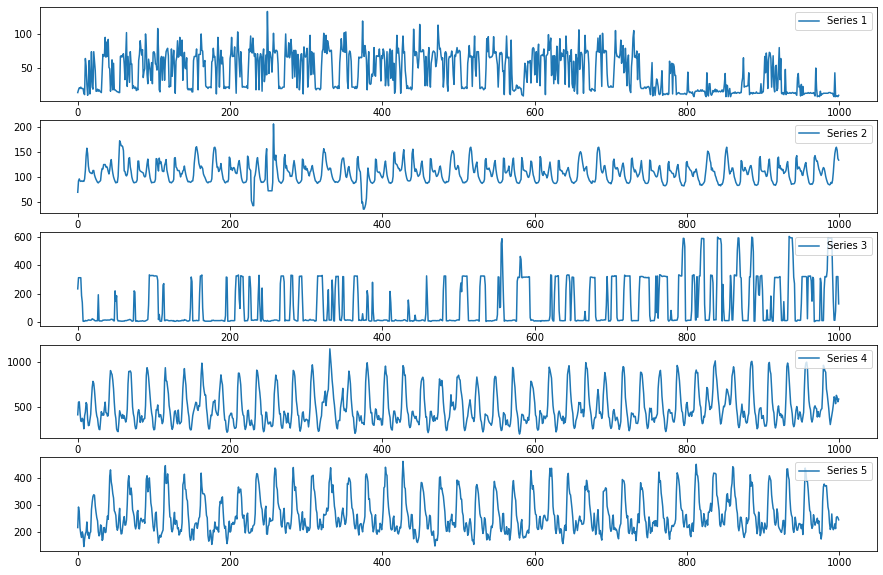

In [6]:
# print(dataset.describe())

# Plot the first 1000 time steps for the first 5 series
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    ax[i].plot(dataset.iloc[:1000, i], label=f'Series {i+1}')
    ax[i].legend(loc='upper right')
plt.show()

## Univariate Time Series Scenario

In [7]:
# Univariate Time Series Analysis
single_series = dataset.iloc[:, 3]

# Create a datetime index
date_rng = pd.date_range(start='2012-01-01', freq='H', periods=len(single_series))
single_series.index = date_rng

# Extract the time and series components
series = single_series.to_numpy()
#time = single_series.index.to_numpy()
time = np.arange(0, len(series))

In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

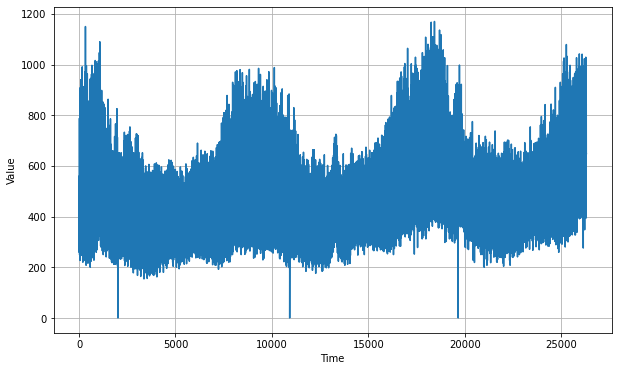

In [9]:
plot_series(time,series)

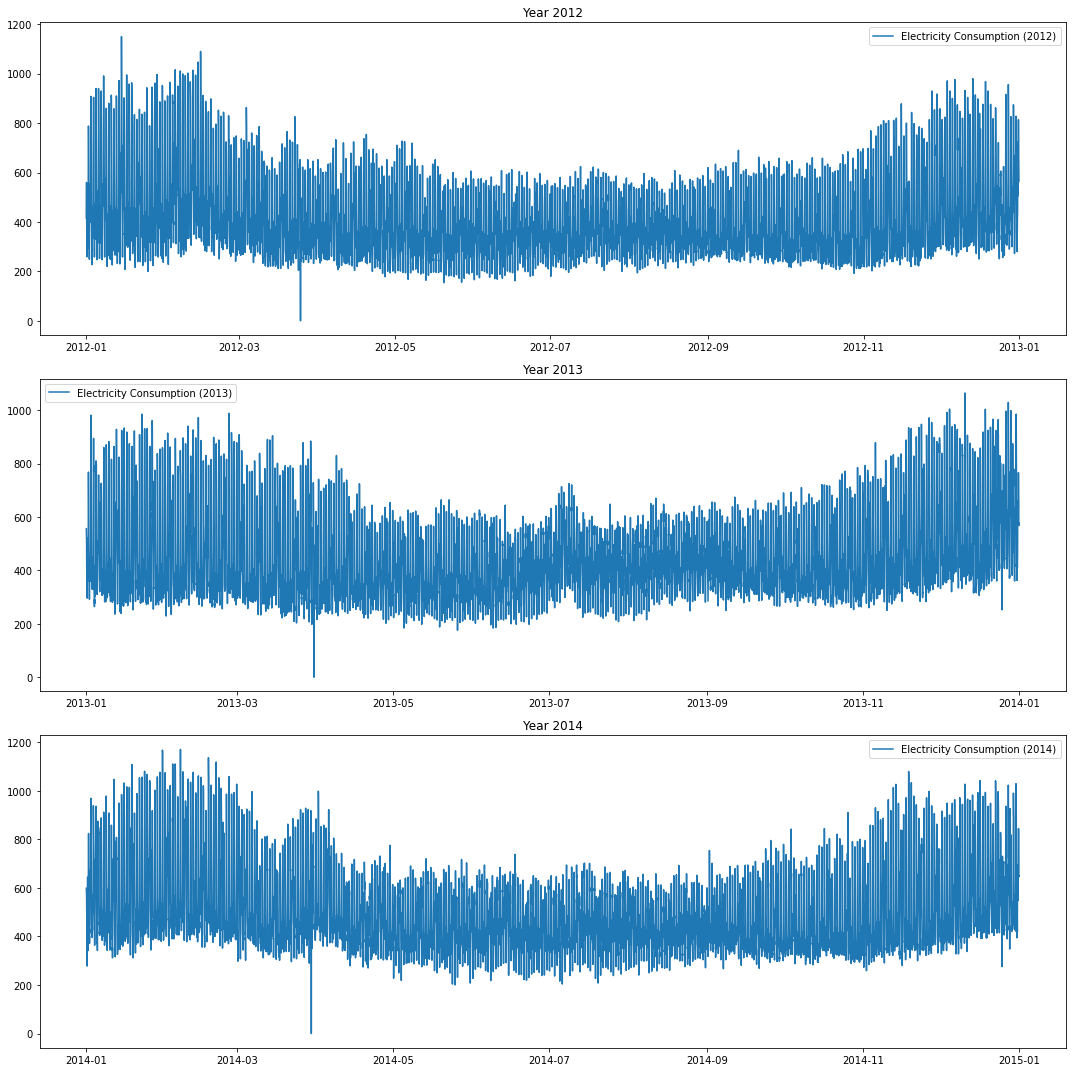

In [10]:
# Determine the number of years in the dataset
num_years = single_series.index.year.nunique()

# Create subplots for each year
fig, ax = plt.subplots(num_years, 1, figsize=(15, num_years * 5))

for i, year in enumerate(single_series.index.year.unique()):
    yearly_data = single_series[single_series.index.year == year]
    ax[i].plot(yearly_data, label=f'Electricity Consumption ({year})')
    ax[i].set_title(f'Year {year}')
    ax[i].legend()

plt.tight_layout()
plt.show()

## Time Series Analysis - ACF, PACF and Classical Decomposition

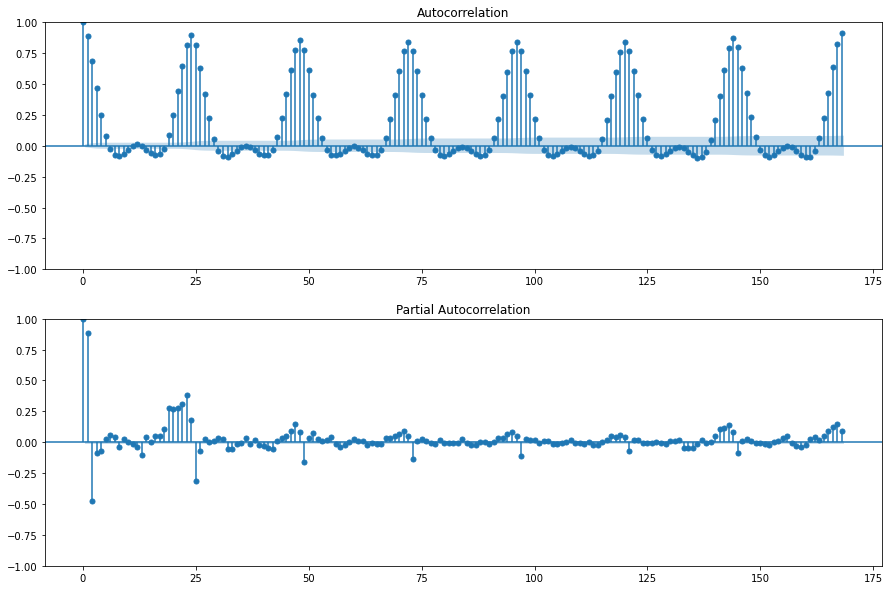

In [11]:
# Visualizing Autocorrelations
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(single_series, lags=168, ax=ax[0])
plot_pacf(single_series, lags=168, ax=ax[1], method='ywm')
plt.show()

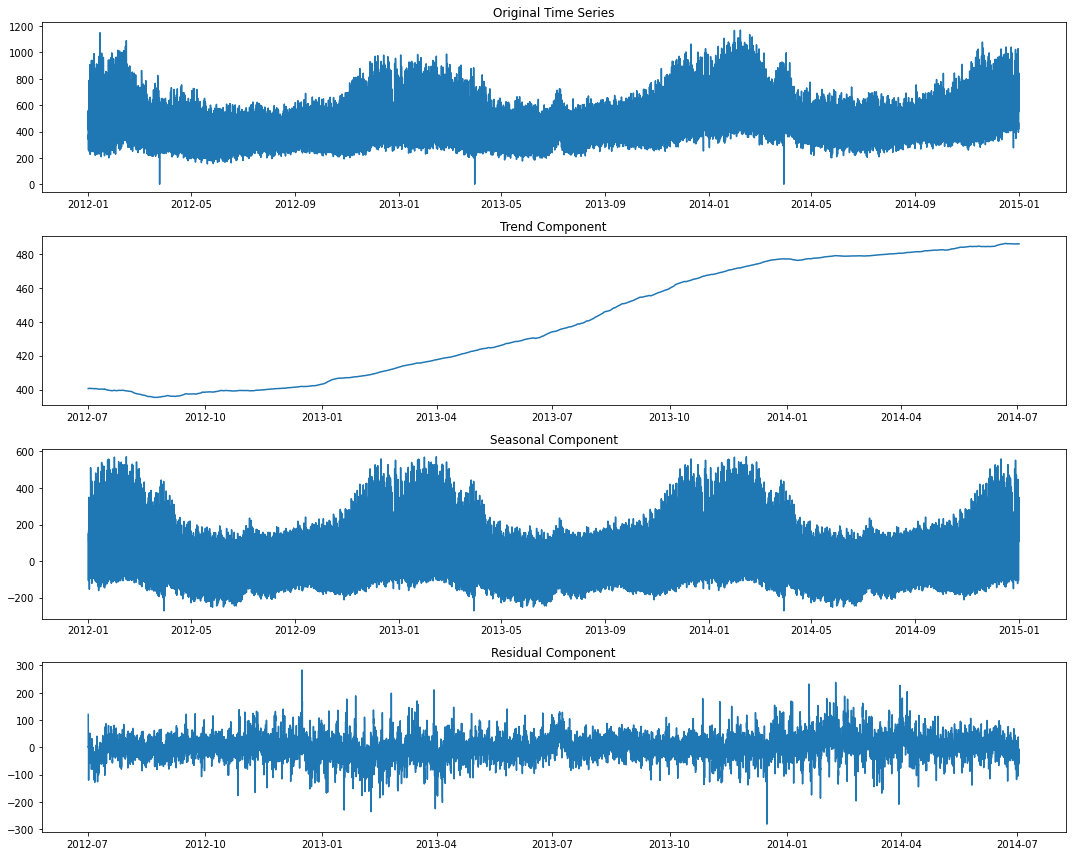

In [12]:
# Decompose the time series into trend and seasonality components

# Perform seasonal decomposition (yearly seasonality - see period arg)
decomposition = seasonal_decompose(single_series, model='additive', period=365*24)
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(15, 12))
ax[0].plot(single_series, label='Original')
ax[0].set_title('Original Time Series')
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_title('Trend Component')
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_title('Seasonal Component')
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_title('Residual Component')
plt.tight_layout()
plt.show()

## Gramian Angular Field (GAF) Transformation - Theory

Gramian Angular Fields (GAFs) are a type of image representation that encode temporal dependencies in time series data. GAFs project time series points into a polar coordinate system, where the value is encoded in the angular cosine while the radius corresponds to the time index of each point. This transformation not only preserves temporal dependencies but also creates a unique image for each time series. The encoding steps are as follows:


**1. Rescaling:** Normalizing a time series $X = \left\{x_1,x_2, \dots, x_n\right\}$ to the interval $[-1,1]$ by applying mean normalization:

$$
\tilde{x}_i = \frac{\left(x_i - max(X)\right)+\left(x_i - min(X)\right)}{max(X) - min(X)}.
$$

**2. Representing in polar coordinates:** Compute the polar coordinates of the scaled time series by computing angular cosine:

$$
        \begin{cases}
        \phi=\arccos \left(\tilde{x}_i\right), & -1 \leq \tilde{x}_i \leq 1, \; \tilde{x}_i \in \tilde{X}\\
        r=\frac{t_i}{N}, & t_i \in \mathbb{N}
        \end{cases}
$$

**3. Calculate Gramian Angular Matrices:** Consider the pairwise trigonometric sum/difference of each point in the time series data to identify temporal correlations within different time intervals.

$$
        GASF = [\cos(\phi_i + \phi_j)] = \left[\begin{array}{cccc} \cos(\phi_1 + \phi_1) & \cos(\phi_1 + \phi_2) & \cdots & \cos(\phi_1 + \phi_n) \\ 
        \cos(\phi_2 + \phi_1) & \cos(\phi_2 + \phi_2) & \cdots & \cos(\phi_2 + \phi_n) \\
        \cdots & \cdots & \cdots & \cdots \\
        \cos(\phi_n + \phi_1) & \cos(\phi_n + \phi_2) & \cdots & \cos(\phi_n + \phi_n) \end{array}\right],
$$

$$
GADF = [\sin(\phi_i - \phi_j)].
$$

Observe that the time dimensionality is encoded into the geometry of the Gram Matrix as the position moves from top-left to bottom-right. Additionally, the transformation is bijective as $\cos(\phi)$ is monotonic when $\phi \in [0,\pi]$. This not only explains the uniqueness of the obtained image but also allows for the reconstruction of the original time series from the main diagonal entries of the GAFs.

## Testing GAF Transform on Full Series

_Note: Applying the GAF transform on the full time series is computationally expensive, and takes time to load. To keep in mind to assess feasibility when applying transforms on data windows._

In [ ]:
# Create a GAF transformer
gasf = GramianAngularField(method='summation')
# Apply the GAF transformation to the time series data (COMMENT THIS IF USING np.load!)
# gasf_data = gasf.fit_transform(single_series.to_numpy().reshape(1, -1))

# Loading pre-transformed saved data
gasf_data = np.load('gasf_data.npy')

In [ ]:
print(gasf_data.shape)

In [ ]:
# Visualize the GASF image
plt.figure(figsize=(10, 10))
plt.imshow(gasf_data[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field (GAF) Image')
plt.colorbar()
plt.show()

In [ ]:
# Using a Gramian Angular Difference Field
gadf = GramianAngularField(method='difference')
# gadf_data = gadf.fit_transform(single_series.to_numpy().reshape(1, -1))

# Loading pre-transformed saved data
gadf_data = np.load('gadf_data.npy')

In [ ]:
# GADF Visualization
plt.figure(figsize=(10, 10))
plt.imshow(gadf_data[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field (GAF) Image')
plt.colorbar()
plt.show()

Run the next cell only **once** to save the results of the transformation to local folder, since the GASF/GADF appear to be computationally expensive operations.

In [ ]:
# Saving results of GASF and GADF transform
# np.save('gasf_data.npy', gasf_data)
# np.save('gadf_data.npy', gadf_data)

## Split the Dataset

In [13]:
# 80-20 split for training-validation
split_time = int(len(series) * 0.8)

# Get the training and validation set 
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

## Prepare Features and Labels

We need to prepare the time series data into features and labels for training our model. This is mainly achieved by performing a _windowing_ operation - we group consecutive measurement values into one feature, and the next measurement will be the label.

In [14]:
# Parameters
window_size = 24*7 #  model will use the past week's worth of data (24 hours*7 days = 168) to make predictions.
batch_size = 32
shuffle_buffer_size = 1000
stride = 1 # number of skips used as the sampling window slides across the entire dataset.

_Note: To inspect and compare the windowed dataset to the original time series, disable/comment the shuffle window code line._

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, stride):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size (number of time windows that are processed in each iteration of training)
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size (note stride argument)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [16]:
dataset_windowed = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size, stride)

## Deeper Look at Windowed Dataset

In [17]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset_windowed.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


In [18]:
total_elements = 0
for _ in dataset_windowed:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 653


In [19]:
def get_window_samples(dataset, num_samples):
    # Helper function to retrieve a specified number of window samples from the dataset
    window_samples = []
    for features, label in dataset.unbatch().take(num_samples):
        window_samples.append((features.numpy(), label.numpy()))
    return window_samples

In [20]:
num_samples = 3
window_samples = get_window_samples(dataset_windowed, num_samples)

for i, (features, label) in enumerate(window_samples):
    print(f"Window {i + 1}:")
    print("Features:")
    print(features)
    print("Label:")
    print(label)
    print("\n")

Window 1:
Features:
[ 442.  712.  939.  992. 1002.  942.  723.  572.  506.  470.  370.  334.
  366.  428.  498.  515.  490.  483.  390.  450.  400.  392.  452.  475.
  483.  671.  967.  938.  904.  890.  702.  644.  564.  484.  380.  306.
  358.  404.  460.  527.  616.  598.  539.  632.  610.  560.  590.  535.
  529.  772. 1014.  977.  890.  783.  752.  644.  588.  520.  422.  350.
  354.  440.  457.  467.  548.  660.  734.  616.  531.  400.  412.  428.
  531.  669.  846.  926.  994.  902.  648.  565.  483.  448.  344.  332.
  344.  418.  477.  541.  496.  408.  430.  462.  386.  394.  394.  422.
  475.  810.  962. 1047. 1010.  880.  686.  612.  492.  460.  354.  338.
  342.  428.  475.  495.  488.  454.  444.  454.  348.  350.  336.  336.
  404.  652. 1006. 1090.  984.  945.  703.  594.  523.  468.  354.  334.
  322.  410.  481.  521.  422.  398.  384.  503.  452.  458.  420.  466.
  449.  675.  912.  844.  894.  826.  679.  542.  485.  432.  334.  312.
  306.  376.  462.  504.  485. 

In [21]:
# Original Training Data for Reference
print(series_train)

[415. 556. 560. ... 356. 386. 440.]


In [22]:
print(len(series_train))

21043


## Test Window Generator for GAF

Now that we have a working function for generating data windows on our training data/time series, we need a similar function for generating GAF-transformed data windows.

In [23]:
def windowed_GAF_generator(series, window_size, batch_size, shuffle_buffer, stride):
    # Testing window function with generator
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    for window in dataset:
        window = window.numpy()
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        yield gaf_transformed, window[-1] # return a generator object

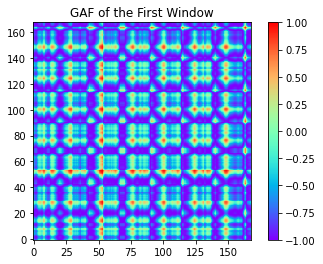

First Window Shape:
(1, 168, 168)
Label:
634.0


In [24]:
window_generator = windowed_GAF_generator(series_train, window_size, batch_size, shuffle_buffer_size, stride)
first_window_gaf, first_window_label = next(window_generator)

plt.imshow(first_window_gaf[0], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title("GAF of the First Window")
plt.show()

print("First Window Shape:")
print(first_window_gaf.shape) # check dimensions of GAF window

print("Label:")
print(first_window_label)

In [25]:
print(first_window_gaf[0].shape)

(168, 168)


## Mean Normalization on Labels

The GAF transform performs the mean normalization within the built in function. We will need to apply mean normalization of the labels as well for the training to be consistent. The mean normalization will need to be performed relative to each window of time series data. 

Here, we update the `windowed_GAF_generator` function for mean normalization on our labels.

In [26]:
def windowed_GAF_generator(series, window_size, batch_size, shuffle_buffer, stride):
    
    # Testing window function with generator (UPDATED FOR MEAN NORMALIZATION)
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    for window in dataset:
        window = window.numpy()
        
        # Calculate min and max of the window
        window_min = np.min(window[:-1])
        window_max = np.max(window[:-1])
        
        # Mean normalize the target (window is automatically mean normalized during GAF transform)
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        normalized_target = ((window[-1] - window_max) + (window[-1] - window_min)) / (window_max - window_min)
        
        yield gaf_transformed, normalized_target # return a generator object

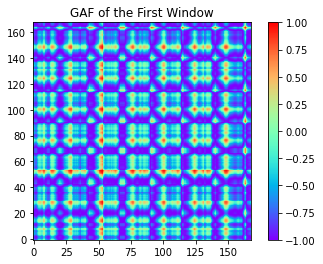

First Window Shape:
(1, 168, 168)
Label:
0.06544502617801047


In [27]:
window_generator = windowed_GAF_generator(series_train, window_size, batch_size, shuffle_buffer_size, stride)
first_window_gaf, first_window_label = next(window_generator)

plt.imshow(first_window_gaf[0], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title("GAF of the First Window")
plt.show()

print("First Window Shape:")
print(first_window_gaf.shape) # check dimensions of GAF window

print("Label:")
print(first_window_label)

## Data Preprocessing by Gramian Angular Fields (GAFs)

The peviously defined `windowed_GAF_generator` are generator functions. Now that we have verified it works, we update it further to include capture groups for all GAF-transformed windows and normalized targets. 

In [28]:
def windowed_GAF_generator(series, window_size, stride):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    gaf_outputs = []
    targets = []
    for window in dataset:
        window = window.numpy()
        
        # Calculate min and max of the window
        window_min = np.min(window[:-1])
        window_max = np.max(window[:-1])
        
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        gaf_outputs.append(tf.convert_to_tensor(gaf_transformed[0]))
        
        # Mean normalize the target
        normalized_target = ((window[-1] - window_max) + (window[-1] - window_min)) / (window_max - window_min)
        targets.append(tf.convert_to_tensor(normalized_target))

    return gaf_outputs, targets

In [29]:
stride = 24 # We use a stride of one day (24 hours) for more efficient training.
gaf_outputs, targets = windowed_GAF_generator(series, window_size, stride)
gaf_dataset = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))

## Inspecting GAF Data Processing Pipeline (Verification)

Now that we have inspected the outputs which seem to be appropriate, we can apply batching and shuffling of the dataset prior to training.

In [30]:
print(gaf_dataset.element_spec)

(TensorSpec(shape=(168, 168), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


In [31]:
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (168, 168)
shape of second element: ()


In [32]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 1089


In [33]:
# Extract the first GAF-transformed window and target value
first_gaf_window, first_target = next(iter(gaf_dataset))

# Convert the tensors to numpy arrays
first_gaf_window_np = first_gaf_window.numpy()
first_target_np = first_target.numpy()

print("First GAF-transformed window:")
print(first_gaf_window)
print("\nFirst target value:", first_target_np)

First GAF-transformed window:
tf.Tensor(
[[-0.48416984 -0.7826506  -0.78918362 ... -0.98436306 -0.93900668
  -0.89045821]
 [-0.7826506  -0.96150051 -0.96435031 ... -0.97667178 -0.99909987
  -0.99688533]
 [-0.78918362 -0.96435031 -0.96709246 ... -0.97434842 -0.99859591
  -0.99766295]
 ...
 [-0.98436306 -0.97667178 -0.97434842 ... -0.75755873 -0.85912401
  -0.91476864]
 [-0.93900668 -0.99909987 -0.99859591 ... -0.85912401 -0.93474685
  -0.97089152]
 [-0.89045821 -0.99688533 -0.99766295 ... -0.91476864 -0.97089152
  -0.99274965]], shape=(168, 168), dtype=float64)

First target value: 0.06544502617801047


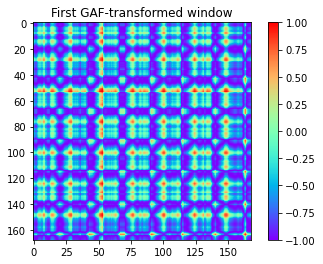

In [34]:
import matplotlib.pyplot as plt

plt.imshow(first_gaf_window_np, cmap='rainbow')
plt.colorbar()
plt.title("First GAF-transformed window")
plt.show()

In [35]:
# Apply batching on the GAF dataset
gaf_dataset = gaf_dataset.batch(batch_size).prefetch(1)

In [36]:
# Shuffle the dataset
gaf_dataset = gaf_dataset.shuffle(shuffle_buffer_size)

In [37]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 35


In [38]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168, 168)
shape of second element: (32,)


## Implementation of Skip-GRU Layer:

In [39]:
class SkipGRU(tf.keras.layers.Layer):

    def __init__(self,
                 units,
                 p=1,
                 activation='relu',
                 return_sequences=False,
                 return_state=False,
                 **kwargs):

        '''
        Recurrent-skip layer, see Section 3.4 in the LSTNet paper.
        
        Parameters:
        __________________________________
        units: int.
            Number of hidden units of the GRU cell.

        p: int.
            Number of skipped hidden cells.

        activation: str, function.
            Activation function, see https://www.tensorflow.org/api_docs/python/tf/keras/activations.

        return_sequences: bool.
            Whether to return the last output or the full sequence.

        return_state: bool.
            Whether to return the last state in addition to the output.

        **kwargs: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell.
        '''

        if p < 1:
            raise ValueError('The number of skipped hidden cells cannot be less than 1.')

        self.units = units
        self.p = p
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.timesteps = None
        self.cell = tf.keras.layers.GRUCell(units=units, activation=activation, **kwargs)

        super(SkipGRU, self).__init__()

    def build(self, input_shape):

        if self.timesteps is None:
            self.timesteps = input_shape[1]

            if self.p > self.timesteps:
                raise ValueError('The number of skipped hidden cells cannot be greater than the number of timesteps.')

    def call(self, inputs):

        '''
        Parameters:
        __________________________________
        inputs: tf.Tensor.
            Layer inputs, 2-dimensional tensor with shape (n_samples, filters) where n_samples is the batch size
            and filters is the number of channels of the convolutional layer.

        Returns:
        __________________________________
        outputs: tf.Tensor.
            Layer outputs, 2-dimensional tensor with shape (n_samples, units) if return_sequences == False,
            3-dimensional tensor with shape (n_samples, n_lookback, units) if return_sequences == True where
            n_samples is the batch size, n_lookback is the number of past time steps used as input and units
            is the number of hidden units of the GRU cell.

        states: tf.Tensor.
            Hidden states, 2-dimensional tensor with shape (n_samples, units) where n_samples is the batch size
            and units is the number of hidden units of the GRU cell.
        '''

        outputs = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        states = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        initial_states = tf.zeros(
            shape=(tf.shape(inputs)[0], self.units),
            dtype=tf.float32
        )

        for t in tf.range(self.timesteps):

            if t < self.p:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=initial_states
                )

            else:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=states.read(t - self.p)
                )

            outputs = outputs.write(index=t, value=output)
            states = states.write(index=t, value=state)

        outputs = tf.transpose(outputs.stack(), [1, 0, 2])
        states = tf.transpose(states.stack(), [1, 0, 2])

        if not self.return_sequences:
            outputs = outputs[:, -1, :]

        if self.return_state:
            states = states[:, -1, :]
            return outputs, states

        else:
            return outputs

## Kernal Regularizer
Regularization helper function for controlling against overfitting.

In [40]:
def kernel_regularizer(regularizer, regularization_factor):

    '''
    Parameters:
    __________________________________
    regularizer: str.
        Regularizer, either 'L1', 'L2' or 'L1L2'.

    regularization_factor: float.
        Regularization factor.
    '''
    
    if regularizer == 'L1':
        return tf.keras.regularizers.L1(l1=regularization_factor)

    elif regularizer == 'L2':
        return tf.keras.regularizers.L2(l2=regularization_factor)

    elif regularizer == 'L1L2':
        return tf.keras.regularizers.L1L2(l1=regularization_factor, l2=regularization_factor)

    else:
        raise ValueError('Undefined regularizer {}.'.format(regularizer))

## LSTNet Main Model Architecture:

In [41]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs.
    x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper. <---- NEW!
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [42]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

In [43]:
 # Print the model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 166, 64)      256         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 166, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 gru (GRU)                      (None, 166, 100)     49800       ['dropout[0][0]']                
                                                                                              

## Model Training

In [44]:
# Set the learning rate
learning_rate = 7.0795e-06 # optimal from Tuning Process (loss minimized)

# Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [45]:
# Train the model
history = model.fit(dataset_windowed,epochs=5)

Epoch 1/5
653/653 [==============================] - 165s 246ms/step - loss: 71.2433 - mae: 71.7154
Epoch 2/5
653/653 [==============================] - 203s 311ms/step - loss: 38.0881 - mae: 38.5549
Epoch 3/5
653/653 [==============================] - 211s 322ms/step - loss: 30.8747 - mae: 31.3406
Epoch 4/5
653/653 [==============================] - 204s 313ms/step - loss: 29.3019 - mae: 29.7667
Epoch 5/5
653/653 [==============================] - 218s 333ms/step - loss: 28.8360 - mae: 29.2995


## Visualize MAE and Loss

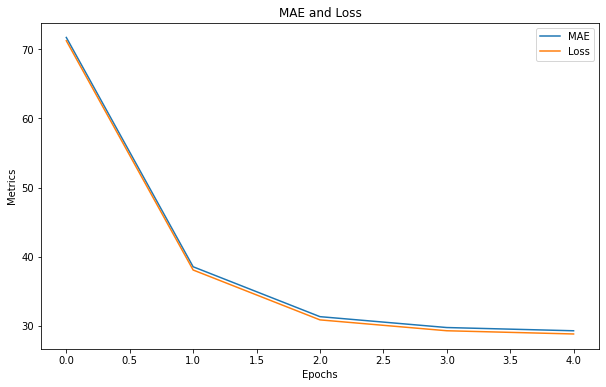

In [46]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Model Prediction (One-step forecasting)

In [47]:
def model_forecast(model, series, window_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    
    # Generate TF Dataset from series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    
    # Flatten windows by putting elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    ds = ds.batch(32).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(ds)
    
    return forecast

In [48]:
# Compute the forecast for all the series
forecast = model_forecast(model, series, window_size).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[split_time - window_size:-1]

817/817 [==============================] - 68s 83ms/step


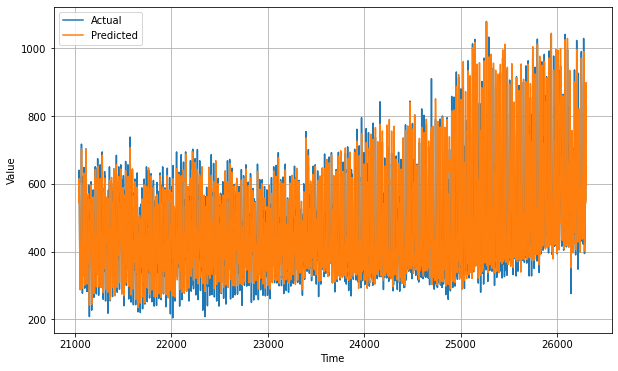

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

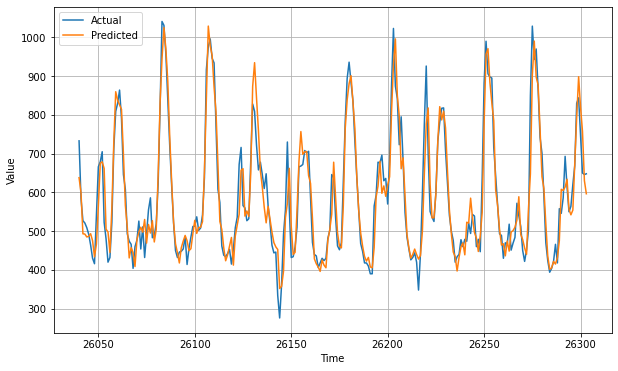

In [50]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_valid))

zoom_time_valid = time_valid[zoom_start_idx:]
zoom_series_valid = series_valid[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_valid, zoom_series_valid, label="Actual")
plt.plot(zoom_time_valid, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Forecasting Evaluation

In [51]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [52]:
# Generate naive forecast
naive_forecast = series_valid[:-1]

# Compute metrics for naive forecast
mse_naive, mae_naive = compute_metrics(series_valid[1:], naive_forecast)

print("Naive Forecast - Mean Squared Error (MSE):", mse_naive)
print("Naive Forecast - Mean Absolute Error (MAE):", mae_naive)

Naive Forecast - Mean Squared Error (MSE): 4951.533460076045
Naive Forecast - Mean Absolute Error (MAE): 51.24942965779468


In [53]:
mse, mae = compute_metrics(series_valid, forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1692.86, mae: 30.31 for forecast


## Additional Evaluation Metrics (RSE and Corr)

- Root Relative Squared Error (RSE):
$$
R S E=\frac{\sqrt{\sum_{(i, t) \in \Omega_{T e s t}}\left(Y_{i t}-\hat{Y}_{i t}\right)^2}}{\sqrt{\sum_{(i, t) \in \Omega_{T e s t}}\left(Y_{i t}-\operatorname{mean}(Y)\right)^2}}
$$
- Empirical Correlation Coefficient (CORR)
$$
C O R R=\frac{1}{n} \sum_{i=1}^n \frac{\sum_t\left(Y_{i t}-\operatorname{mean}\left(Y_i\right)\right)\left(\hat{Y}_{i t}-\operatorname{mean}\left(\hat{Y}_i\right)\right)}{\sqrt{\sum_t\left(Y_{i t}-\operatorname{mean}\left(Y_i\right)\right)^2\left(\hat{Y}_{i t}-\operatorname{mean}\left(\hat{Y}_i\right)\right)^2}}
$$

For RSE lower value is better, while for CORR higher value is better.

In [54]:
def compute_rse(true_series, forecast):
    rse_numerator = np.sqrt(np.sum(np.square(true_series - forecast)))
    rse_denominator = np.sqrt(np.sum(np.square(true_series - np.mean(true_series))))
    rse = rse_numerator / rse_denominator
    return rse

In [55]:
def compute_corr(true_series, forecast):
    # Reshape the data if it's a single time series (1D)
    if len(true_series.shape) == 1:
        true_series = true_series.reshape(1, -1)
        forecast = forecast.reshape(1, -1)

    n = true_series.shape[0]
    corrs = []

    for i in range(n):
        y_true_i = true_series[i]
        y_pred_i = forecast[i]
        corr = np.corrcoef(y_true_i, y_pred_i)[0, 1]
        corrs.append(corr)

    # Calculate the average correlation across all time series
    return np.mean(corrs)

## Modifying LSTNet Architecture for GAF Input

Note that we modify the Input layer to accept the GAF 2D tensor as the input, and the Covolutional Component to perform deeper feature extraction and dimensionality reduction (with MaxPooling), before reshaping as an appropriate sequential input to the Recurrent Components.

In [56]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs (MODIFIED)
    x = tf.keras.layers.Input(shape=(n_lookback,n_lookback,n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper. (MODIFIED)
    c = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper.
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

## Initialize Modified Model

In [57]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

In [58]:
 # Print the model summary 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 168, 168, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 166, 166, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 83, 83, 64)   0           ['conv2d[0][0]']                 
                                                                                            

## Modified Model Training

In [59]:
# Set the learning rate
learning_rate = 0.001

# Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
#optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0) # apply gradient clipping in case of gradient explosion

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [60]:
# Train the model on GAF dataset
history = model.fit(gaf_dataset,epochs=10)

Epoch 1/10
35/35 [==============================] - 56s 1s/step - loss: 0.4772 - mae: 0.7409
Epoch 2/10
35/35 [==============================] - 56s 2s/step - loss: 0.1000 - mae: 0.2905
Epoch 3/10
35/35 [==============================] - 57s 2s/step - loss: 0.0673 - mae: 0.2145
Epoch 4/10
35/35 [==============================] - 59s 2s/step - loss: 0.0554 - mae: 0.1866
Epoch 5/10
35/35 [==============================] - 61s 2s/step - loss: 0.0518 - mae: 0.1837
Epoch 6/10
35/35 [==============================] - 61s 2s/step - loss: 0.0487 - mae: 0.1782
Epoch 7/10
35/35 [==============================] - 60s 2s/step - loss: 0.0448 - mae: 0.1689
Epoch 8/10
35/35 [==============================] - 61s 2s/step - loss: 0.0439 - mae: 0.1701
Epoch 9/10
35/35 [==============================] - 61s 2s/step - loss: 0.0375 - mae: 0.1534
Epoch 10/10
35/35 [==============================] - 61s 2s/step - loss: 0.0334 - mae: 0.1378


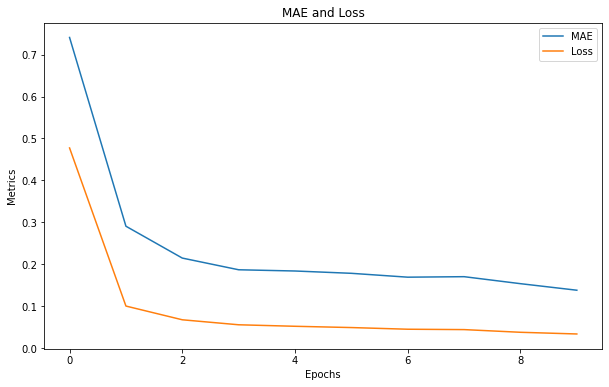

In [61]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Modified Model Prediction

In [62]:
def model_forecast(model, series, window_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window

    Returns:
      forecast (numpy array) - array containing predictions
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # GAF Transformation on each data window
    gasf = GramianAngularField(method='summation')
    gaf_outputs = []
    for window in ds:
        window = window.numpy()
        gaf_transformed = gasf.fit_transform(window.reshape(1, -1))
        gaf_outputs.append(gaf_transformed[0])

    # Convert GAF outputs to a numpy array
    gaf_outputs = np.array(gaf_outputs)

    # Reshape GAF outputs to 4D (batch_size, height, width, channels)
    gaf_outputs = gaf_outputs.reshape(-1, window_size, window_size, 1)

    # Get predictions on the entire dataset
    forecast = model.predict(gaf_outputs)

    return forecast

In [63]:
# Compute the forecast for all the series
forecast = model_forecast(model, series, window_size).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[split_time - window_size:-1]

817/817 [==============================] - 394s 481ms/step


## Forecasting Evaluation

In [64]:
def model_forecast(model, series, window_size):
    """
    Modified model_forecast function for GAFs.
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # GAF Transformation on each data window
    gasf = GramianAngularField(method='summation')
    gaf_outputs = []
    
    
    window_mins = []
    window_maxs = []
    for window in ds:
        window = window.numpy()
        window_mins.append(np.min(window))
        window_maxs.append(np.max(window))
        gaf_transformed = gasf.fit_transform(window.reshape(1, -1))
        gaf_outputs.append(gaf_transformed[0])

    # Convert GAF outputs to a numpy array
    gaf_outputs = np.array(gaf_outputs)

    # Reshape GAF outputs to 4D (batch_size, height, width, channels)
    gaf_outputs = gaf_outputs.reshape(-1, window_size, window_size, 1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(gaf_outputs)
    
    return forecast, window_mins, window_maxs

In [65]:
forecast, window_mins, window_maxs = model_forecast(model, series, window_size)

817/817 [==============================] - 418s 512ms/step


In [66]:
forecast_denorm = np.zeros_like(forecast)
for i in range(len(forecast)):
    min_val = window_mins[i]
    max_val = window_maxs[i]
    forecast_denorm[i] = forecast[i] * (max_val - min_val) + (max_val + min_val) / 2

In [67]:
# Slice the forecast to get only the predictions for the validation set
forecast = forecast_denorm[split_time - window_size:-1, 0]

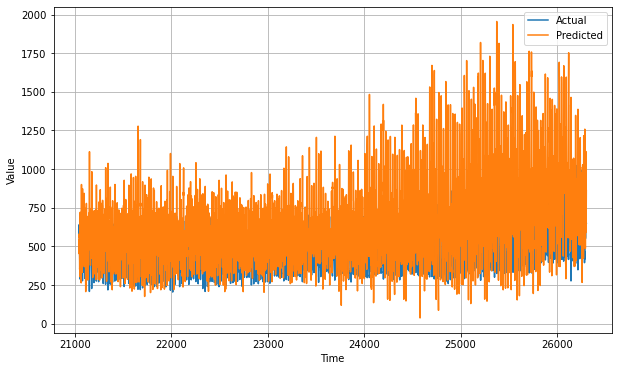

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

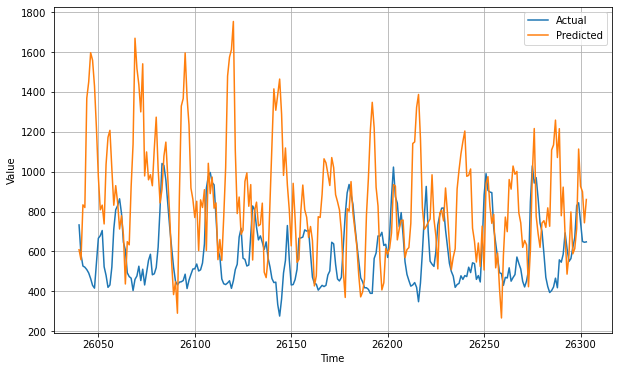

In [69]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_valid))

zoom_time_valid = time_valid[zoom_start_idx:]
zoom_series_valid = series_valid[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_valid, zoom_series_valid, label="Actual")
plt.plot(zoom_time_valid, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Forecasting Evaluation

In [70]:
# Generate naive forecast
naive_forecast = series_valid[:-1]

# Compute metrics for naive forecast
mse_naive, mae_naive = compute_metrics(series_valid[1:], naive_forecast)

print("Naive Forecast - Mean Squared Error (MSE):", mse_naive)
print("Naive Forecast - Mean Absolute Error (MAE):", mae_naive)

Naive Forecast - Mean Squared Error (MSE): 4951.533460076045
Naive Forecast - Mean Absolute Error (MAE): 51.24942965779468


In [71]:
mse, mae = compute_metrics(series_valid, forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 116505.96, mae: 230.95 for forecast


In [72]:
mse_list = []
mae_list = []

# Iterate through the validation set
for t in range(len(series_valid)):
    true_series_t = series_valid[:t+1]
    forecast_t = forecast[:t+1]
    
    mse_t, mae_t = compute_metrics(true_series_t, forecast_t)
    
    mse_list.append(mse_t)
    mae_list.append(mae_t)

# Convert lists to numpy arrays
mse_array = np.array(mse_list)
mae_array = np.array(mae_list)

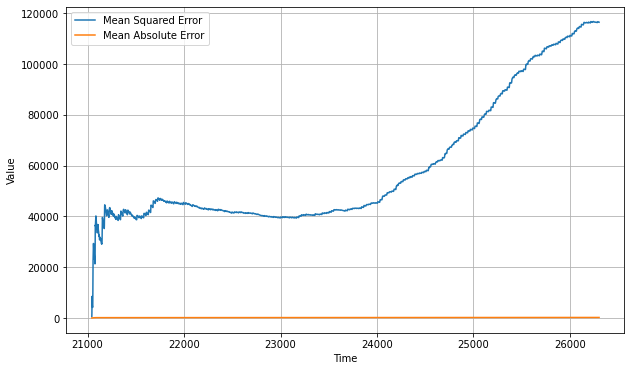

In [73]:
# Plot the MSE and MAE over time
plt.figure(figsize=(10, 6))
plt.plot(time_valid, mse_array, label="Mean Squared Error")
plt.plot(time_valid, mae_array, label="Mean Absolute Error")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [74]:
abs_error_list = []
mae_list = []

# Iterate through the validation set
for t in range(len(series_valid)):
    true_series_t = series_valid[:t+1]
    forecast_t = forecast[:t+1]
    
    abs_error_t = np.abs(true_series_t - forecast_t)
    mae_t = np.mean(abs_error_t)
    
    abs_error_list.append(abs_error_t[-1])  # Append the last element in the array
    mae_list.append(mae_t)

# Convert lists to numpy arrays
abs_error_array = np.array(abs_error_list)
mae_array = np.array(mae_list)

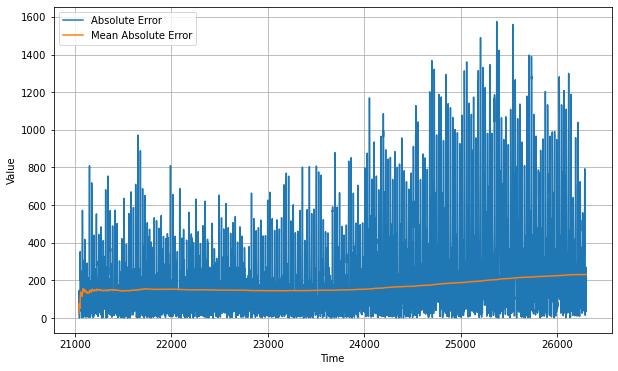

In [75]:
# Plot the Absolute Error and Mean Absolute Error over time
plt.figure(figsize=(10, 6))
plt.plot(time_valid, abs_error_array, label="Absolute Error")
plt.plot(time_valid, mae_array, label="Mean Absolute Error")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

# Hyperparameter Tuning

### Split Dataset into 60-20-20 (Train-Validation-Test)

Validation Set is used for hyperparameter tuning without peeking into Test set

In [230]:
# 80-20 split for training-test
split_time = int(len(series) * 0.8)

# Get the training and validation set 
time_train = time[:split_time]
series_train = series[:split_time]
time_test = time[split_time:]
series_test = series[split_time:]

# Further split into 60-20-20 (Train-Validation-Test)
split_time_val = int(len(series_train) * 0.75)
time_val = time_train[split_time_val:]
series_val = series_train[split_time_val:]
time_train = time_train[:split_time_val]
series_train = series_train[:split_time_val]


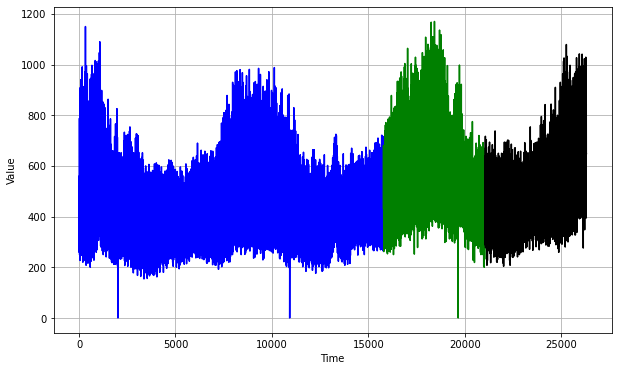

In [231]:
plt.figure(figsize=(10, 6))
plt.plot(time_train, series_train, '-',c='b')
plt.plot(time_val, series_val, '-',c='g')
plt.plot(time_test, series_test, '-',c='black')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [232]:
# Parameters
window_size = 24*7 #  model will use the past week's worth of data (24 hours*7 days = 168) to make predictions.
batch_size = 32
shuffle_buffer_size = 1000
stride = 10 # number of skips used as the sampling window slides across the entire dataset.

In [233]:
dataset_windowed_train = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size, stride)
dataset_windowed_val = windowed_dataset(series_val, window_size, batch_size, shuffle_buffer_size, stride)

In [234]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset_windowed_train.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


In [235]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset_windowed_val.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


## Implement Hyperparameter Tuning on Univariate Series

### 1. Baseline Architecture 

In [236]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs.
    x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper. <---- NEW!
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [237]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

Implement Early stopping. Training stops after val_loss does not improve across 3 consecutive iterations

In [240]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [241]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
init_weights = model.get_weights()
model.set_weights(init_weights)
#model.set_weights(tf.keras.models.clone_model(model).get_weights())

# Set the learning rate
#learning_rate = 7.0795e-06 # optimal from Tuning Process (loss minimized)
epochs = 10
initial_learning_rate = 0.01
final_learning_rate = 7.0795e-06  # optimal from Tuning Process (loss minimized)
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/(epochs))
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

# Set the optimizer 
#optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipnorm=1.0)# Adam optimizer appears to run quite slowly
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9, clipnorm=1.0)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset_windowed_train,epochs=20, validation_data = dataset_windowed_val,callbacks=[stop_early])

Epoch 1/20
49/49 [==============================] - 27s 420ms/step - loss: 53.4796 - mae: 53.9325 - val_loss: 85.0852 - val_mae: 85.5374
Epoch 2/20
49/49 [==============================] - 28s 560ms/step - loss: 44.5462 - mae: 44.9966 - val_loss: 45.2144 - val_mae: 45.6658
Epoch 3/20
49/49 [==============================] - 23s 464ms/step - loss: 38.0327 - mae: 38.4837 - val_loss: 44.9208 - val_mae: 45.3736
Epoch 4/20
49/49 [==============================] - 22s 452ms/step - loss: 35.8736 - mae: 36.3237 - val_loss: 46.9378 - val_mae: 47.3896
Epoch 5/20
49/49 [==============================] - 24s 473ms/step - loss: 35.0131 - mae: 35.4634 - val_loss: 48.9360 - val_mae: 49.3874
Epoch 6/20
49/49 [==============================] - 23s 469ms/step - loss: 34.8834 - mae: 35.3326 - val_loss: 47.1189 - val_mae: 47.5710


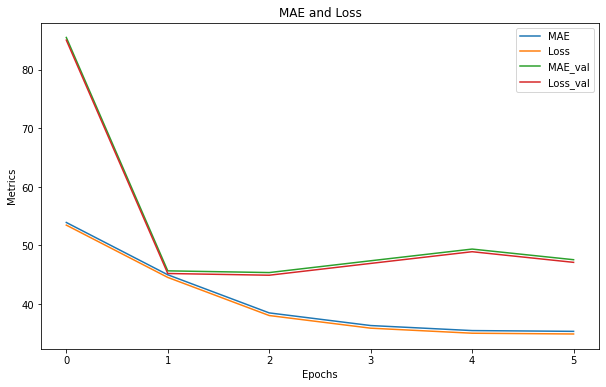

In [242]:
#Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']
mae_val = history.history['val_mae']
loss_val = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, mae_val, label='MAE_val')
plt.plot(epochs, loss_val, label='Loss_val')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

Validation and Train Loss and MAE are all very high. Will need to tune parameters to improve model performance.

### 2. Hyperparameter Tuning: Learning Rate

In [243]:
!pip install -q -U keras-tuner

In [244]:
import keras_tuner as kt

In [245]:
# Reset states generated by Keras
#tf.keras.backend.clear_session()

In [246]:
def model_tuner(hp):
    #Tune the learning rate for the optimizer
    #Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling="log")

    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate,momentum = 0.9, clipnorm=1.0),
              metrics=["mae"])

    return model

In [247]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

In [248]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
init_weights = model.get_weights()
model.set_weights(init_weights)

In [249]:
#tuner = kt.Hyperband(model_tuner,
#                     objective='val_mae',
#                     max_epochs=10,
#                     factor=3,
#                     hyperband_iterations=2,
#                     overwrite = False,
#                     directory="./",
#                     project_name="lrtuner"
#                     )

In [250]:
#tuner.search(dataset_windowed_train, validation_data=dataset_windowed_val, epochs=epochs, callbacks=[stop_early])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}.
#""")

In [251]:
#best_model = tuner.get_best_models(1)[0]

In [252]:
#best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#del model

In [253]:
# Reset the weights
init_weights = model.get_weights()
model.set_weights(init_weights)
epochs = 10
#learning_rate = 9.799925653711856e-05 # optimal from Tuning Process (MAE minimized)

initial_learning_rate = 0.01
final_learning_rate = 9.799925653711856e-05 # optimal from Tuning Process (MAE minimized)
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/(epochs))
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9, clipnorm=1.0)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset_windowed_train,epochs=epochs, validation_data = dataset_windowed_val, callbacks=[stop_early])

Epoch 1/10
49/49 [==============================] - 27s 427ms/step - loss: 113.4630 - mae: 113.9111 - val_loss: 295.1808 - val_mae: 295.5886
Epoch 2/10
49/49 [==============================] - 20s 414ms/step - loss: 62.7914 - mae: 63.2293 - val_loss: 85.3313 - val_mae: 85.7757
Epoch 3/10
49/49 [==============================] - 20s 403ms/step - loss: 48.9015 - mae: 49.3476 - val_loss: 51.2000 - val_mae: 51.6465
Epoch 4/10
49/49 [==============================] - 21s 419ms/step - loss: 46.5707 - mae: 47.0180 - val_loss: 52.3665 - val_mae: 52.8181
Epoch 5/10
49/49 [==============================] - 21s 422ms/step - loss: 46.2587 - mae: 46.7087 - val_loss: 51.7552 - val_mae: 52.2054
Epoch 6/10
49/49 [==============================] - 20s 410ms/step - loss: 46.3306 - mae: 46.7803 - val_loss: 50.5501 - val_mae: 51.0015
Epoch 7/10
49/49 [==============================] - 20s 415ms/step - loss: 45.9758 - mae: 46.4274 - val_loss: 50.3897 - val_mae: 50.8376
Epoch 8/10
49/49 [===================

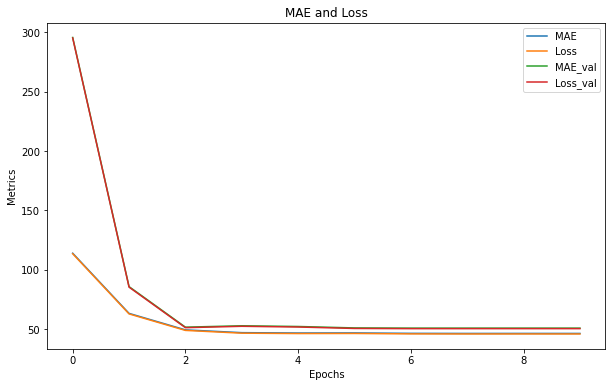

In [254]:
#Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']
mae_val = history.history['val_mae']
loss_val = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, mae_val, label='MAE_val')
plt.plot(epochs, loss_val, label='Loss_val')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [255]:
def model_forecast(model, series, window_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    
    # Generate TF Dataset from series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    
    # Flatten windows by putting elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    ds = ds.batch(32).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(ds)
    
    return forecast

In [256]:
# Compute the forecast for all the series
forecast = model_forecast(model, series, window_size).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[split_time - window_size:-1]

817/817 [==============================] - 88s 107ms/step


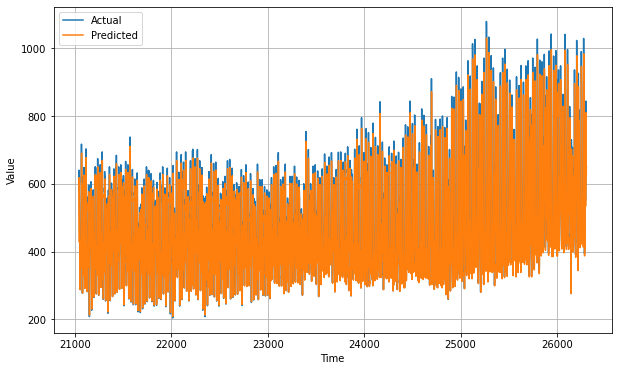

In [257]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, series_test, label="Actual")
plt.plot(time_test, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

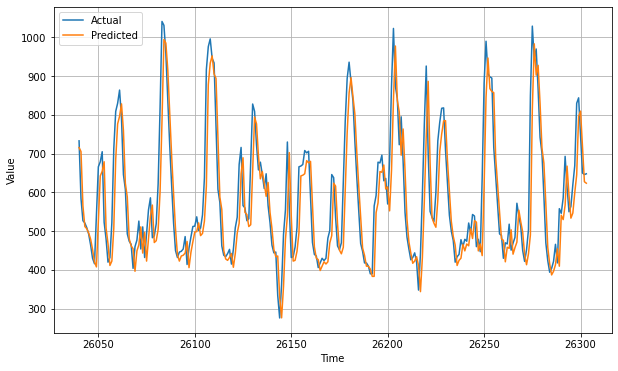

In [258]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_test))

zoom_time_test = time_test[zoom_start_idx:]
zoom_series_test = series_test[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_test, zoom_series_test, label="Actual")
plt.plot(zoom_time_test, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

### 3. Hyperparameter Tuning: Model Parameters and Learning Rate (Without Skip_GRU layer)

In [259]:
def build_fn_mod(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor, # Regularization factor. (float)
             activation ):
        
    # Inputs.
    x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation=activation, return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper. <---- NEW!
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    #s = SkipGRU(units=skip_gru_units, activation=activation, return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(c)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [260]:
def model_tuner(hp):

    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-7, max_value=1e-2, sampling="log")
    activation = hp.Choice("activation", ["relu"])#, "tanh"])
    dropout = hp.Float("dropout", min_value=0, max_value=1, sampling="linear")
    filters = hp.Int('filters', min_value=32, max_value=512, step=32)
    kernel_size = hp.Int('kernel_size', min_value=1, max_value=10, step=1)
    gru_units = hp.Int('gru_units', min_value=10, max_value=500, step=10)
    skip = hp.Int('skip', min_value=1, max_value=10, step=1)
    lags = hp.Int('lags', min_value=1, max_value=10, step=1)
    num_heads = hp.Int('num_heads', min_value=1, max_value=10, step=1)
    regularizer = hp.Choice("regularizer", ["L1", "L2","L1L2"])
    regularization_factor = hp.Float("regularization_factor", min_value=0, max_value=0.1, sampling="linear")
    
    model = build_fn_mod(
        n_targets = 1, # univariate time series test
        n_lookback = window_size,
        filters = filters,
        kernel_size = kernel_size,
        gru_units = gru_units,
        skip_gru_units = 50,
        skip = skip,
        lags = lags,
        num_heads = num_heads,
        dropout = dropout,
        regularizer = regularizer,
        regularization_factor = regularization_factor,
        activation = activation)
    
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum = 0.9, clipnorm=1.0),
              metrics=["mae"])

    return model

In [261]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [262]:
# Reset the weights
#init_weights = model.get_weights()
#model.set_weights(init_weights)

In [263]:
#tuner = kt.Hyperband(model_tuner,
#                     objective='val_mae',
#                     max_epochs=10,
#                     factor=3,
#                     hyperband_iterations=5,
#                     overwrite = False,
#                     directory="./",
#                     project_name="tuner"
#                     )

In [264]:
epochs=10
#tuner.search(dataset_windowed_train, validation_data=dataset_windowed_val, epochs=epochs, callbacks=[stop_early])

#Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}. The optimal filters is {best_hps.get('filters')}. 
#The optimal dropout is {best_hps.get('dropout')}. The optimal kernel size is {best_hps.get('kernel_size')}.
#The optimal gru units is {best_hps.get('gru_units')}. The optimal skip is {best_hps.get('skip')}.
#The optimal lags is {best_hps.get('lags')}. The optimal num_heads is {best_hps.get('num_heads')}.
#The optimal regularizer is {best_hps.get('regularizer')}. 
#The optimal regularization_factor is {best_hps.get('regularization_factor')}.
#""")

In [265]:
#best_model = tuner.get_best_models(1)[0]

In [266]:
#best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [267]:
model = build_fn_mod(
        n_targets = 1, # univariate time series test
        n_lookback = window_size,
        filters = 16,
        kernel_size = 6,
        gru_units = 200,
        skip_gru_units = 50,
        skip = 7,
        lags = 3,
        num_heads = 4,
        dropout = 0.017645445509965052,
        regularizer = 'L1L2',
        regularization_factor = 0.051315816547158305,
        activation = 'relu')

epochs = 10
initial_learning_rate = 0.01
final_learning_rate = 0.005177316038450406 # optimal from Tuning Process (MAE minimized)
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/(epochs))
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)
    
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum = 0.9, clipnorm=1.0),
              metrics=["mae"])

In [268]:
# Reset states generated by Keras
#tf.keras.backend.clear_session()
#init_weights = best_model.get_weights()
#best_model.set_weights(init_weights)

In [269]:
# Train the model
history = model.fit(dataset_windowed_train,epochs=epochs, validation_data = dataset_windowed_val, callbacks=[stop_early])

Epoch 1/10
49/49 [==============================] - 33s 610ms/step - loss: 301.0638 - mae: 290.0072 - val_loss: 141.1216 - val_mae: 130.4340
Epoch 2/10
49/49 [==============================] - 36s 722ms/step - loss: 100.3304 - mae: 90.1434 - val_loss: 70.7028 - val_mae: 60.9616
Epoch 3/10
49/49 [==============================] - 36s 739ms/step - loss: 78.5763 - mae: 69.2826 - val_loss: 132.3073 - val_mae: 123.4136
Epoch 4/10
49/49 [==============================] - 35s 718ms/step - loss: 74.5092 - mae: 65.9852 - val_loss: 77.6489 - val_mae: 69.5163
Epoch 5/10
49/49 [==============================] - 36s 734ms/step - loss: 60.8168 - mae: 53.1218 - val_loss: 57.8622 - val_mae: 50.7898
Epoch 6/10
49/49 [==============================] - 39s 799ms/step - loss: 59.1275 - mae: 52.4801 - val_loss: 77.1411 - val_mae: 70.7526
Epoch 7/10
49/49 [==============================] - 36s 731ms/step - loss: 55.0799 - mae: 48.9093 - val_loss: 58.6375 - val_mae: 52.7514
Epoch 8/10
49/49 [================

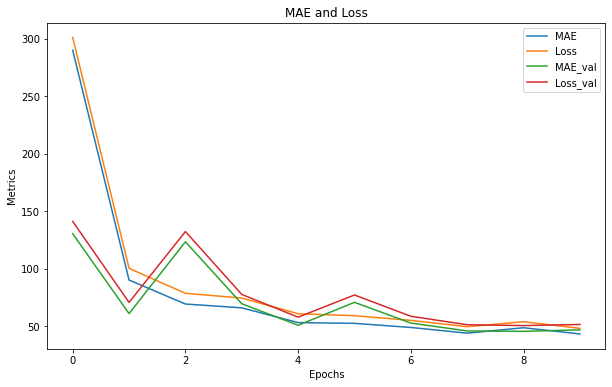

In [270]:
#Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']
mae_val = history.history['val_mae']
loss_val = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, mae_val, label='MAE_val')
plt.plot(epochs, loss_val, label='Loss_val')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [271]:
# Compute the forecast for all the series
forecast = model_forecast(model, series, window_size).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[split_time - window_size:-1]

817/817 [==============================] - 178s 217ms/step


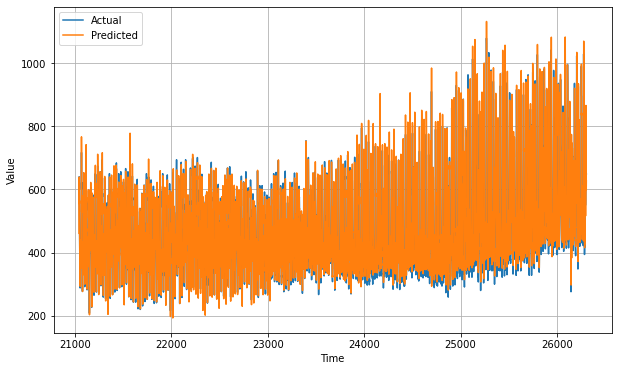

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, series_test, label="Actual")
plt.plot(time_test, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

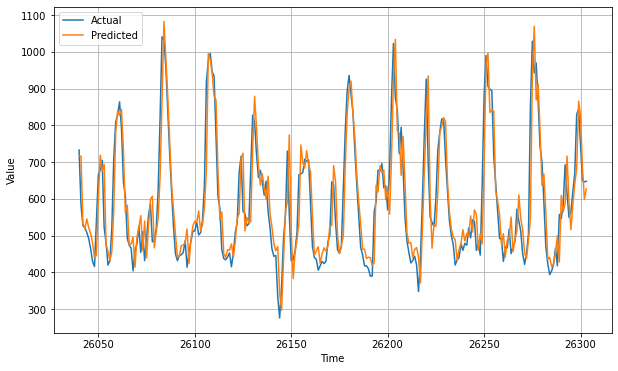

In [273]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_test))

zoom_time_test = time_test[zoom_start_idx:]
zoom_series_test = series_test[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_test, zoom_series_test, label="Actual")
plt.plot(zoom_time_test, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Implement Hyperparameter Tuning on GAF Univariate Series

In [274]:
stride = 24 # We use a stride of one day (24 hours) for more efficient training.
# Train dataset
gaf_outputs, targets = windowed_GAF_generator(series_train, window_size, stride)
gaf_dataset_train = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))
# Validation dataset
gaf_outputs, targets = windowed_GAF_generator(series_val, window_size, stride)
gaf_dataset_val = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))

In [275]:
# Apply batching on the GAF dataset
gaf_dataset_train = gaf_dataset_train.batch(batch_size).prefetch(1)
# Shuffle the dataset
gaf_dataset_train = gaf_dataset_train.shuffle(shuffle_buffer_size)

# Apply batching on the GAF dataset
gaf_dataset_val = gaf_dataset_val.batch(batch_size).prefetch(1)
# Shuffle the dataset
gaf_dataset_val = gaf_dataset_val.shuffle(shuffle_buffer_size)

### 1. Baseline Architecture 

In [276]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs (MODIFIED)
    x = tf.keras.layers.Input(shape=(n_lookback,n_lookback,n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper. (MODIFIED)
    c = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper.
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [277]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

In [278]:
# Set the learning rate
#learning_rate = 0.001
epochs = 10
initial_learning_rate = 0.01
final_learning_rate = 0.005177316038450406 # optimal from Tuning Process (MAE minimized)
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/(epochs))
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

# Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
#optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0) # apply gradient clipping in case of gradient explosion

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [279]:
# Train the model
history = model.fit(gaf_dataset_train,epochs=epochs, validation_data = gaf_dataset_val, callbacks=[stop_early])

Epoch 1/10
21/21 [==============================] - 50s 2s/step - loss: 116.2443 - mae: 116.6083 - val_loss: 0.0758 - val_mae: 0.2557
Epoch 2/10
21/21 [==============================] - 40s 2s/step - loss: 0.3123 - mae: 0.6343 - val_loss: 0.6057 - val_mae: 1.0430
Epoch 3/10
21/21 [==============================] - 39s 2s/step - loss: 0.1929 - mae: 0.4749 - val_loss: 0.2563 - val_mae: 0.5963
Epoch 4/10
21/21 [==============================] - 40s 2s/step - loss: 0.0677 - mae: 0.2565 - val_loss: 0.3189 - val_mae: 0.6771


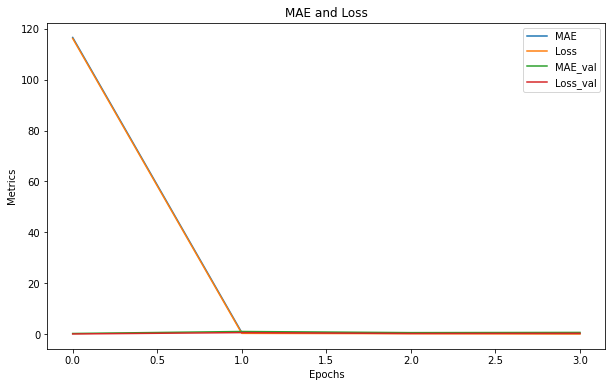

In [280]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']
mae_val = history.history['val_mae']
loss_val = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, mae_val, label='MAE_val')
plt.plot(epochs, loss_val, label='Loss_val')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [281]:
def model_forecast(model, series, window_size):
    """
    Modified model_forecast function for GAFs.
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # GAF Transformation on each data window
    gasf = GramianAngularField(method='summation')
    gaf_outputs = []
    
    
    window_mins = []
    window_maxs = []
    for window in ds:
        window = window.numpy()
        window_mins.append(np.min(window))
        window_maxs.append(np.max(window))
        gaf_transformed = gasf.fit_transform(window.reshape(1, -1))
        gaf_outputs.append(gaf_transformed[0])

    # Convert GAF outputs to a numpy array
    gaf_outputs = np.array(gaf_outputs)

    # Reshape GAF outputs to 4D (batch_size, height, width, channels)
    gaf_outputs = gaf_outputs.reshape(-1, window_size, window_size, 1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(gaf_outputs)
    
    return forecast, window_mins, window_maxs

In [282]:
forecast, window_mins, window_maxs = model_forecast(model, series, window_size)
forecast_denorm = np.zeros_like(forecast)
for i in range(len(forecast)):
    min_val = window_mins[i]
    max_val = window_maxs[i]
    forecast_denorm[i] = forecast[i] * (max_val - min_val) + (max_val + min_val) / 2
# Slice the forecast to get only the predictions for the validation set
forecast = forecast_denorm[split_time - window_size:-1, 0]

817/817 [==============================] - 424s 518ms/step


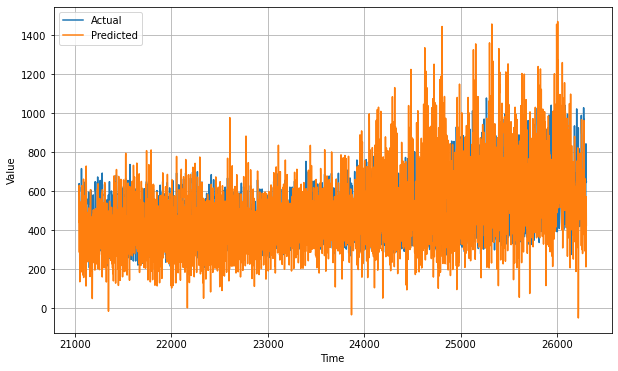

In [283]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, series_test, label="Actual")
plt.plot(time_test, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

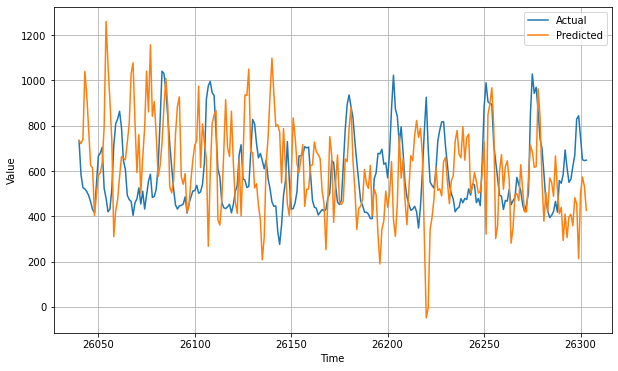

In [284]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_test))

zoom_time_test = time_test[zoom_start_idx:]
zoom_series_test = series_test[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_test, zoom_series_test, label="Actual")
plt.plot(zoom_time_test, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

### 2. Hyperparameter Tuning: Model Parameters

In [285]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
#del model

In [286]:
def build_fn_mod(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs (MODIFIED)
    x = tf.keras.layers.Input(shape=(n_lookback,n_lookback,n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper. (MODIFIED)
    c = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper.
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    #s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(c)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [287]:
def model_tuner(hp):

    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-7, max_value=1e-2, sampling="log")
    dropout = hp.Float("dropout", min_value=0, max_value=1, sampling="linear")
    filters = hp.Int('filters', min_value=16, max_value=32, step=16)
    kernel_size = hp.Int('kernel_size', min_value=1, max_value=10, step=1)
    gru_units = hp.Int('gru_units', min_value=10, max_value=500, step=10)
    skip = hp.Int('skip', min_value=1, max_value=10, step=1)
    lags = hp.Int('lags', min_value=1, max_value=10, step=1)
    num_heads = hp.Int('num_heads', min_value=1, max_value=10, step=1)
    regularizer = hp.Choice("regularizer", ["L1", "L2","L1L2"])
    regularization_factor = hp.Float("regularization_factor", min_value=0, max_value=0.1, sampling="linear")
    
    model_hp = build_fn_mod(
        n_targets = 1, # univariate time series test
        n_lookback = window_size,
        filters = filters,
        kernel_size = kernel_size,
        gru_units = gru_units,
        skip_gru_units = 50,
        skip = skip,
        lags = lags,
        num_heads = num_heads,
        dropout = dropout,
        regularizer = regularizer,
        regularization_factor = regularization_factor,)
    
    model_hp.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum = 0.9, clipnorm=1.0),
              metrics=["mae"])

    return model_hp

In [288]:
tuner = kt.Hyperband(model_tuner,
                     objective='val_mae',
                     max_epochs=10,
                     factor=3,
                     hyperband_iterations=5,
                     overwrite = False,
                     directory="./",
                     project_name="gaftuner"
                     )

INFO:tensorflow:Reloading Tuner from ./gaftuner\tuner0.json


In [289]:
epochs=10
#tuner.search(gaf_dataset_train, validation_data=gaf_dataset_val, epochs=epochs, callbacks=[stop_early])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}. The optimal filters is {best_hps.get('filters')}. 
#The optimal dropout is {best_hps.get('dropout')}. The optimal kernel size is {best_hps.get('kernel_size')}.
#The optimal gru units is {best_hps.get('gru_units')}. The optimal skip is {best_hps.get('skip')}.
#The optimal lags is {best_hps.get('lags')}. The optimal num_heads is {best_hps.get('num_heads')}.
#The optimal regularizer is {best_hps.get('regularizer')}. 
#The optimal regularization_factor is {best_hps.get('regularization_factor')}.
#""")

In [290]:
# Based on Hyperparameters from Tuning
model = build_fn_mod(
        n_targets = 1, # univariate time series test
        n_lookback = window_size,
        filters = 16,
        kernel_size = 6,
        gru_units = 200,
        skip_gru_units = 50,
        skip = 7,
        lags = 3,
        num_heads = 4,
        dropout = 0.017645445509965052,
        regularizer = 'L1L2',
        regularization_factor = 0.051315816547158305,)

# Set the learning rate
#learning_rate = 0.001
epochs = 10
initial_learning_rate = 0.01
final_learning_rate = 0.0001327632105667843 # optimal from Tuning Process (MAE minimized)
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/(epochs))
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)
    
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate= learning_rate,momentum = 0.9, clipnorm=1.0),
              metrics=["mae"])

In [291]:
# Train the model
history = model.fit(gaf_dataset_train,epochs=epochs, validation_data = gaf_dataset_val, callbacks=[stop_early])

Epoch 1/10
21/21 [==============================] - 20s 735ms/step - loss: 6.9403 - mae: 0.4788 - val_loss: 3.8063 - val_mae: 0.3075
Epoch 2/10
21/21 [==============================] - 17s 821ms/step - loss: 2.0772 - mae: 0.2829 - val_loss: 1.3799 - val_mae: 0.5139
Epoch 3/10
21/21 [==============================] - 15s 724ms/step - loss: 0.7492 - mae: 0.2605 - val_loss: 0.5488 - val_mae: 0.5305
Epoch 4/10
21/21 [==============================] - 15s 728ms/step - loss: 0.2605 - mae: 0.2300 - val_loss: 0.3723 - val_mae: 0.6161
Epoch 5/10
21/21 [==============================] - 15s 718ms/step - loss: 0.1332 - mae: 0.2315 - val_loss: 0.3331 - val_mae: 0.6513
Epoch 6/10
21/21 [==============================] - 16s 757ms/step - loss: 0.1437 - mae: 0.3426 - val_loss: 0.2537 - val_mae: 0.5780
Epoch 7/10
21/21 [==============================] - 15s 723ms/step - loss: 0.0902 - mae: 0.2475 - val_loss: 0.2760 - val_mae: 0.6267
Epoch 8/10
21/21 [==============================] - 15s 691ms/step - 

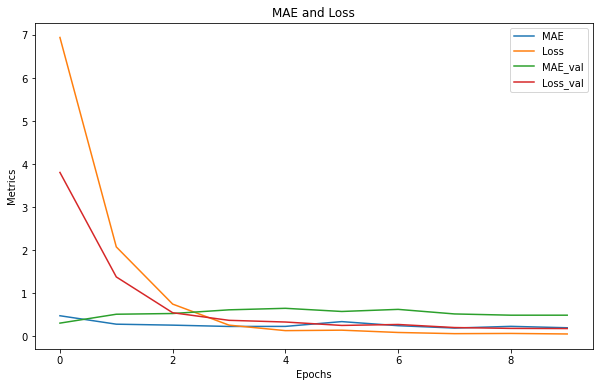

In [292]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']
mae_val = history.history['val_mae']
loss_val = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, mae_val, label='MAE_val')
plt.plot(epochs, loss_val, label='Loss_val')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [293]:
forecast, window_mins, window_maxs = model_forecast(model, series, window_size)
forecast_denorm = np.zeros_like(forecast)
for i in range(len(forecast)):
    min_val = window_mins[i]
    max_val = window_maxs[i]
    forecast_denorm[i] = forecast[i] * (max_val - min_val) + (max_val + min_val) / 2
# Slice the forecast to get only the predictions for the validation set
forecast = forecast_denorm[split_time - window_size:-1, 0]

817/817 [==============================] - 143s 175ms/step


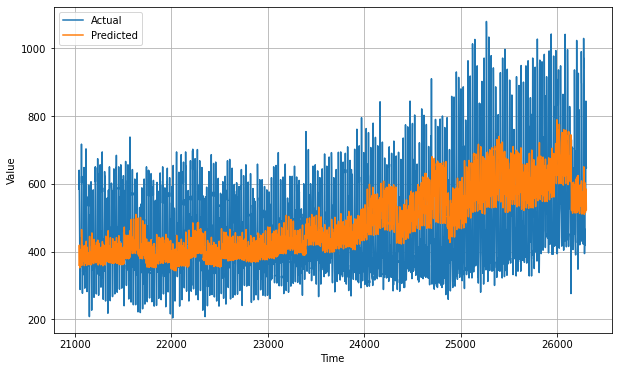

In [294]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, series_test, label="Actual")
plt.plot(time_test, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

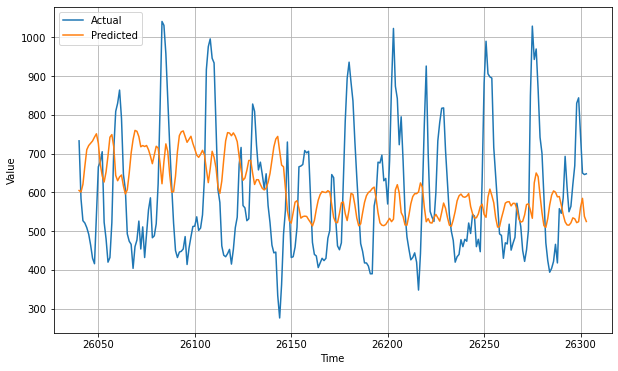

In [295]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_test))

zoom_time_test = time_test[zoom_start_idx:]
zoom_series_test = series_test[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_test, zoom_series_test, label="Actual")
plt.plot(zoom_time_test, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()